# Predicting stimulus using previous choice

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.special import logit

In [2]:
rng = default_rng(999)

## Explanation

- Previous choice weighted by $\log \frac{1-H}{H}$ approximates the prior term $\psi_H(r_{t-1})$.
- One difference between these: Model with previous choice has no decay element -- i.e., if log-likelihood ratio is zero for a large number of consecutive trials, it will *not* decay to zero, while Glaze et al. recursion will
- This might be fixed by using a stochastic decision rule instead of a deterministic one.

In [16]:
def phi(x, c):
    return np.log(np.exp(c + x) + 1) - np.log(np.exp(c) + np.exp(x))

def psi(x, h):
    return phi(x, logit(1 - h))

def prev_choice(x, h): 
    return np.sign(x) * logit(1 - h)

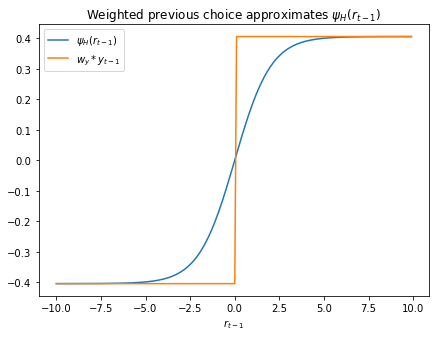

In [41]:
h = 0.4
x = np.arange(-10, 10, 0.1)

fig = plt.figure(figsize=(7,5))

plt.plot(x, psi(x, h), label='$\psi_H(r_{t-1})$')
plt.plot(x, prev_choice(x, h), label='$w_y * y_{t-1}$')
    
plt.xlabel('$r_{t-1}$')
plt.title('Weighted previous choice approximates $\psi_H(r_{t-1})$')
plt.legend();

## Comparison using synthetic data

### Sample trials from Glaze et al. model

In [3]:
def smp_glaze_trials(n_smps, rng, hazard_rate=0.1, noise=0.5, s_init=1):
    
    changes = rng.binomial(1, hazard_rate, n_smps)
    s_right = np.mod(np.cumsum(changes), 2)
    s_smps = s_init * (2 * s_right - 1)
    x_smps = s_smps + rng.normal(0, noise, n_smps)
    
    return s_smps, x_smps

In [9]:
n_trials = 100
h_true = 0.05
x_noise = 1.0

s_smps, x_smps = smp_glaze_trials(n_trials, rng, h_true, x_noise)

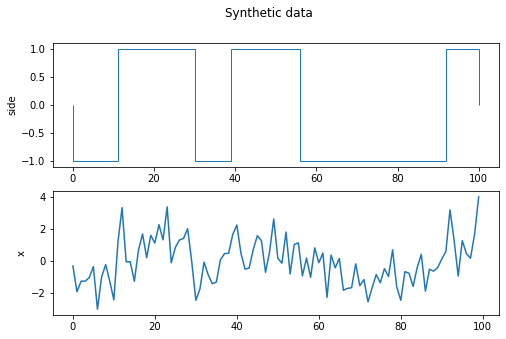

In [10]:
(fig, ax) = plt.subplots(2, 1, figsize=(8, 5))

ax[0].stairs(s_smps)
ax[0].set_ylabel('side')

ax[1].plot(x_smps)
ax[1].set_ylabel('x')

fig.suptitle('Synthetic data');

### Apply filters to data

### Recursive filter from Glaze et al.

In [11]:
def phi(x, c):
    return np.log(np.exp(c + x) + 1) - np.log(np.exp(c) + np.exp(x)) 

def psi(r_prev, hazard_rate):
    return phi(r_prev, logit(1 - hazard_rate))

def log_lik(x, noise):
    return (2 * x) / (noise ** 2)

In [12]:
lik = np.full(n_trials, np.nan)
prior_flt = np.full(n_trials, np.nan)
r_flt = np.full(n_trials, np.nan)
choice_flt = np.full(n_trials, np.nan)

# Initial value for log-odds
r_flt[-1] = 0

for t in range(n_trials):

    # Update prior
    prior_flt[t] = psi(r_flt[t - 1], h_true)
    
    # Compute log-likelihood ratio of observation
    lik[t] = log_lik(x_smps[t], x_noise)
    
    # Update filter
    r_flt[t] = lik[t] + prior_flt[t]
    
    # Make choice by applying threshold to log-odds
    choice_flt[t] = np.sign(r_flt[t])

### GLM with previous choice as predictor

In [13]:
r_glm = np.full(n_trials, np.nan)
choice_glm = np.full(n_trials, np.nan)

choice_glm[-1] = 0

for t in range(n_trials):
    
    # Compute GLM input using likelihood and previous choice
    r_glm[t] = log_lik(x_smps[t], x_noise) + logit(1 - h_true) * choice_glm[t - 1]
    
    # Make choice by applying threshold to log-odds
    choice_glm[t] = np.sign(r_glm[t])

### Compute squared error for filter and GLM

In [14]:
err_flt = (s_smps - choice_flt) ** 2
err_glm = (s_smps - choice_glm) ** 2

### Plot results

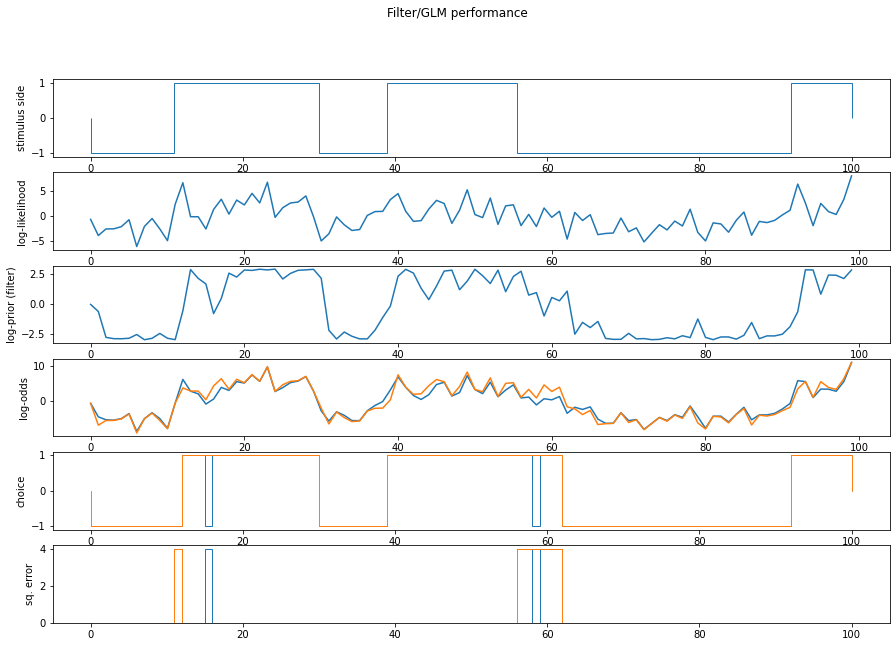

In [15]:
(fig, ax) = plt.subplots(6, 1, figsize=(15, 10))

ax[0].stairs(s_smps)
ax[0].set_ylabel('stimulus side')

ax[1].plot(lik)
ax[1].set_ylabel('log-likelihood')

ax[2].plot(prior_flt)
ax[2].set_ylabel('log-prior (filter)')

ax[3].plot(r_flt)
ax[3].plot(r_glm)
ax[3].set_ylabel('log-odds')

ax[4].stairs(choice_flt)
ax[4].stairs(choice_glm)
ax[4].set_ylabel('choice')

ax[5].stairs(err_flt)
ax[5].stairs(err_glm)
ax[5].set_ylabel('sq. error')

fig.suptitle('Filter/GLM performance');